<a href="https://colab.research.google.com/github/Jaydenzk/DS-Unit-2-Regression-Classification/blob/master/module4/assignment_regression_classification_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 4

## Assignment

- [X] Watch Aaron Gallant's [video #1](https://www.youtube.com/watch?v=pREaWFli-5I) (12 minutes) & [video #2](https://www.youtube.com/watch?v=bDQgVt4hFgY) (9 minutes) to learn about the mathematics of Logistic Regression.
- [X] Do train/validate/test split with the Tanzania Waterpumps data.
- [X] Do one-hot encoding. (Remember it may not work with high cardinality categoricals.)
- [X] Use scikit-learn for logistic regression.
- [X] Get your validation accuracy score.
- [X] Get and plot your coefficients.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [X] Commit your notebook to your fork of the GitHub repo.

> [Do Not Copy-Paste.](https://docs.google.com/document/d/1ubOw9B3Hfip27hF2ZFnW3a3z9xAgrUDRReOEo-FHCVs/edit) You must type each of these exercises in, manually. If you copy and paste, you might as well not even do them. The point of these exercises is to train your hands, your brain, and your mind in how to read, write, and see code. If you copy-paste, you are cheating yourself out of the effectiveness of the lessons.


## Stretch Goals

### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Clean the data. For ideas, refer to [The Quartz guide to bad data](https://github.com/Quartz/bad-data-guide),  a "reference to problems seen in real-world data along with suggestions on how to resolve them." One of the issues is ["Zeros replace missing values."](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values)
- [ ] Make exploratory visualizations.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this problem, you may want to use the parameter `logistic=True`

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from the previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```

#### Pipelines

[Scikit-Learn User Guide](https://scikit-learn.org/stable/modules/compose.html) explains why pipelines are useful, and demonstrates how to use them:

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:
> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

### Reading
- [ ] [How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/)
- [ ] [Always start with a stupid model, no exceptions](https://blog.insightdatascience.com/always-start-with-a-stupid-model-no-exceptions-3a22314b9aaa)
- [ ] [Statistical Modeling: The Two Cultures](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).



In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module4')

     |████████████████████████████████| 92kB 5.7MB/s 
     |████████████████████████████████| 133kB 16.3MB/s 
     |████████████████████████████████| 7.1MB 25.0MB/s 
     |████████████████████████████████| 614kB 43.3MB/s 
     |████████████████████████████████| 225kB 43.7MB/s 
     |████████████████████████████████| 768kB 43.7MB/s 
     |████████████████████████████████| 51kB 22.0MB/s 
     |████████████████████████████████| 194kB 47.5MB/s 
     |████████████████████████████████| 51kB 20.2MB/s 
     |████████████████████████████████| 737kB 40.5MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.3.0-py2.py3-none-any.whl size=145036 sha256=53cf9c2ff794e925fd5d112a4428447eea1a761439111c19249d7c8b1da8c14a
  Stored in directory: /root/.cache/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27085 sha256=df12c2a34d0551ba840346a5c62d5af33b92cfcabe4c56e896de08ef4b9b7e43
  Stored

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd

train_features = pd.read_csv('../data/tanzania/train_features.csv')
train_labels = pd.read_csv('../data/tanzania/train_labels.csv')
test_features = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

assert train_features.shape == (59400, 40)
assert train_labels.shape == (59400, 2)
assert test_features.shape == (14358, 40)
assert sample_submission.shape == (14358, 2)

In [8]:
from sklearn.model_selection import train_test_split

X_train = train_features
y_train = train_labels['status_group']

X_train, X_val, y_train, y_val = train_test_split(
      X_train, y_train, train_size=0.80, test_size=0.20,
      stratify=y_train, random_state=42)
    
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((47520, 40), (11880, 40), (47520,), (11880,))

In [24]:
y_train.value_counts(normalize=True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

In [25]:
y_val.value_counts(normalize=True)

functional                 0.543098
non functional             0.384259
functional needs repair    0.072643
Name: status_group, dtype: float64

In [0]:
X_train_numeric = X_train.select_dtypes('number')
X_val_numeric = X_val.select_dtypes('number')

In [29]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_val_numeric)
accuracy_score(y_val, y_pred)

0.5542087542087543

In [43]:
## cardinality check

X_train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq
recorded_by,47520,1,GeoData Consultants Ltd,47520
public_meeting,44876,2,True,40838
permit,45077,2,True,31071
source_class,47520,3,groundwater,36638
management_group,47520,5,user-group,42027
quantity_group,47520,5,enough,26567
quantity,47520,5,enough,26567
waterpoint_type_group,47520,6,communal standpipe,27642
quality_group,47520,6,good,40598
payment_type,47520,7,never pay,20287


In [44]:
X_train['water_quality'].value_counts(dropna=False)

soft                  40598
salty                  3903
unknown                1503
milky                   658
coloured                403
salty abandoned         276
fluoride                165
fluoride abandoned       14
Name: water_quality, dtype: int64

In [45]:
X_train['source_type'].value_counts(dropna=False)

spring                  13620
shallow well            13507
borehole                 9511
river/lake               8271
rainwater harvesting     1859
dam                       518
other                     234
Name: source_type, dtype: int64

In [46]:
train = X_train.copy()
train['status_group'] = y_train

train.groupby('water_quality')['status_group'].value_counts(normalize=True)

water_quality       status_group           
coloured            functional                 0.496278
                    non functional             0.394541
                    functional needs repair    0.109181
fluoride            functional                 0.769697
                    non functional             0.175758
                    functional needs repair    0.054545
fluoride abandoned  non functional             0.642857
                    functional                 0.357143
milky               functional                 0.550152
                    non functional             0.433131
                    functional needs repair    0.016717
salty               non functional             0.500128
                    functional                 0.452472
                    functional needs repair    0.047399
salty abandoned     functional                 0.514493
                    non functional             0.278986
                    functional needs repair    0.206522
soft

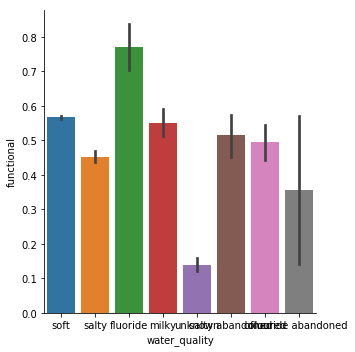

In [47]:
## Visualization

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# this adds a 'functional' col that marks 1 if 'functional'
train['functional'] = (train['status_group']=='functional').astype(int)

# plot
sns.catplot(x='water_quality', y='functional', data=train, kind='bar');

In [48]:
## validation

import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

categorical_features = ['water_quality']
numeric_features = X_train.select_dtypes('number').columns.drop('id').tolist()
features = categorical_features + numeric_features

X_train_subset = X_train[features]
X_val_subset = X_val[features]

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train_subset)
X_val_encoded = encoder.transform(X_val_subset)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)

print('Validation Accuracy', model.score(X_val_scaled, y_val));

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Validation Accuracy 0.5806397306397306


In [49]:
model.coef_[0]

array([ 0.11043539,  0.00616442,  0.05997163,  0.0536506 , -0.30519837,
        0.02624842,  0.01173852, -0.00618977,  0.56162991,  0.21768079,
        0.02099634, -0.00159663,  0.00646561, -0.21197274,  0.08032475,
        0.03426339, -0.07392299])

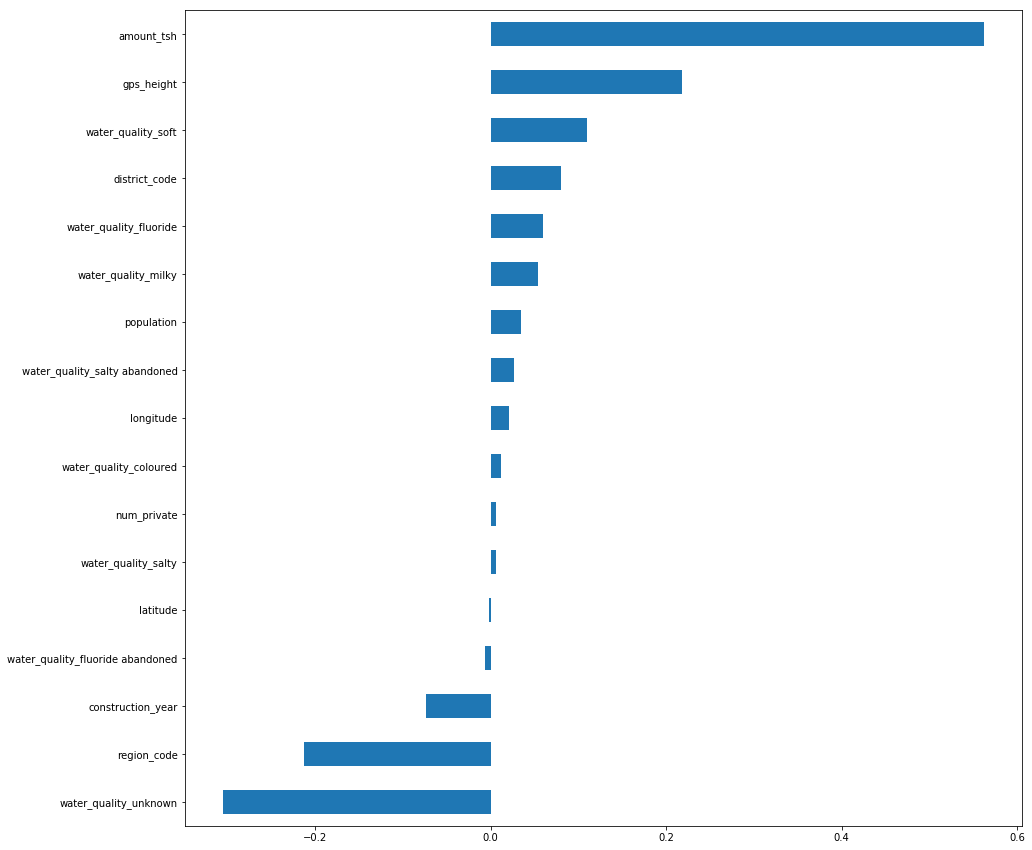

In [51]:
functional_coefficients = pd.Series(
     model.coef_[0],
     X_train_encoded.columns
)

plt.figure(figsize=(15,15))
functional_coefficients.sort_values().plot.barh();